In [19]:
def queryTripsMinMax(dbPath, minRow, maxRow):
	import sqlite3

	db = sqlite3.connect(dbPath)
	cursor = db.cursor()

	cursor.execute('''SELECT startTime, bridgeName, direction, simpleMPH FROM tripsUnique WHERE rowid > ? AND rowid < ?''', (minRow,maxRow))
	result = cursor.fetchall()

	db.close()
	return result

Here tripsUnique is used here instead of trips to get the deduplicated trips table that we made using SQL commands. After looking into the documentation more it turns out that the source of this duplication is actually on the OneBusAway side. According to the link below "Agencies often schedule major changes to their system around a particular date, with one GTFS feed for before the service change and a different GTFS feed for after."

http://developer.onebusaway.org/modules/onebusaway-gtfs-modules/1.3.3/onebusaway-gtfs-merge-cli.html

In [20]:
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
#%matplotlib inline


In [21]:
style.use('seaborn-ticks')

In [22]:
cbColors = [ [86,180,233], [230,159,0], [0,158,115], [240,228,66], [0,114,178],  [213,94,0], [204,121,167], [0,0,0],]
for rgbList in cbColors:
    rgbList[:] = [x / 255 for x in rgbList]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cbColors)

In [23]:
DB_PATH = 'archives/mydb_Aug13_Final'
rows = queryTripsMinMax(DB_PATH, 1, 23000) #Grab all rows, we already know there are about 22k rows

In [24]:
formattedRows = [[dt.datetime.fromtimestamp(int(list[0])), list[1], list[2], float(list[3])]  for list in rows]
df = pd.DataFrame(formattedRows, columns=['datetime','highway','direction','simpleMPH'])

In [25]:
print(df.head())

             datetime highway direction  simpleMPH
0 2017-08-09 19:06:37   SR520         W   3.271172
1 2017-07-25 08:03:46   SR520         W   3.923153
2 2017-07-26 16:31:17   SR520         W   5.026417
3 2017-07-26 16:37:17   SR520         W   5.026417
4 2017-07-26 15:32:18     I90         W   5.182196


In [26]:
df = df.loc[df['simpleMPH'] <= 75] #Remove spurious data
df = df.sort('datetime')
df['date'] = df['datetime'].apply(lambda x: x.date)
df['weekday'] = df['datetime'].apply(lambda x: x.weekday())
from pandas import date_range, to_datetime
df['timeofdaysec'] = df['datetime'].apply(lambda x: (to_datetime(x) -to_datetime(x.date())).total_seconds())

#print(df_WI90['timeofdaysec'])

In [27]:
df_weekdays= df.loc[df['weekday'] < 5]
#df = df_weekdays
df_WI90 = df.loc[(df['highway'] == 'I90') & (df['direction'] == 'W')]
df_EI90 = df.loc[(df['highway'] == 'I90') & (df['direction'] == 'E')]
df_WSR520 = df.loc[(df['highway'] == 'SR520') & (df['direction'] == 'W')]
df_ESR520 = df.loc[(df['highway'] == 'SR520') & (df['direction'] == 'E')]

This is an overview of all our data. Here we can see the closure of the I-90 bridge for the Blue Angels from 8/3-8/6 and that there was no data collected on 8/2 in order to move the recording computer to a new location.

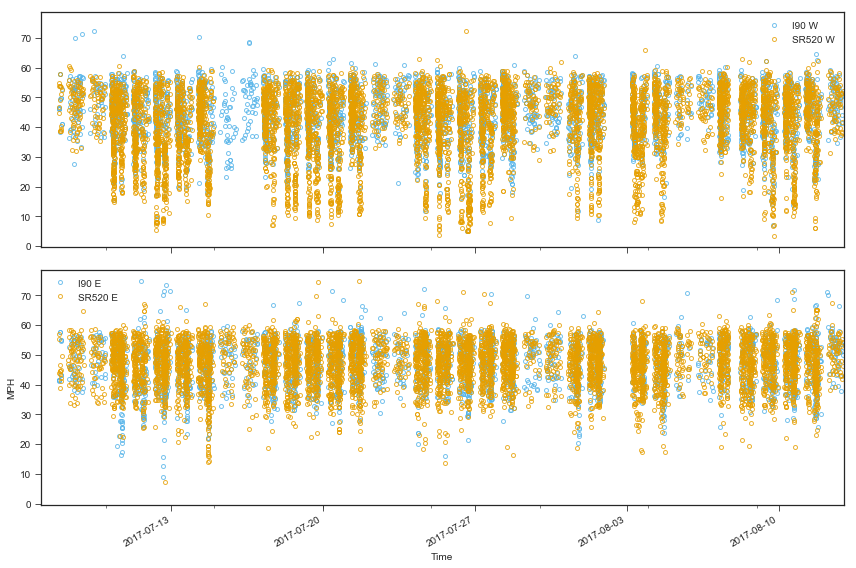

In [45]:
kwargs = {'lw':0, 'marker':'o', 'markersize':4, 'alpha':.8, 'mfc':'none'}
day=19
month=7
start=dt.date(2017,7,7)
end=dt.date(2017,8,13)
fig,(ax1,ax2) = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
df_WI90.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
df_WSR520.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
ax1.legend(['I90 W', 'SR520 W'])
df_EI90.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
df_ESR520.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
ax2.legend(['I90 E', 'SR520 E'])
plt.xlim(start,end)
plt.ylabel('MPH')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Here we can look at specific days:

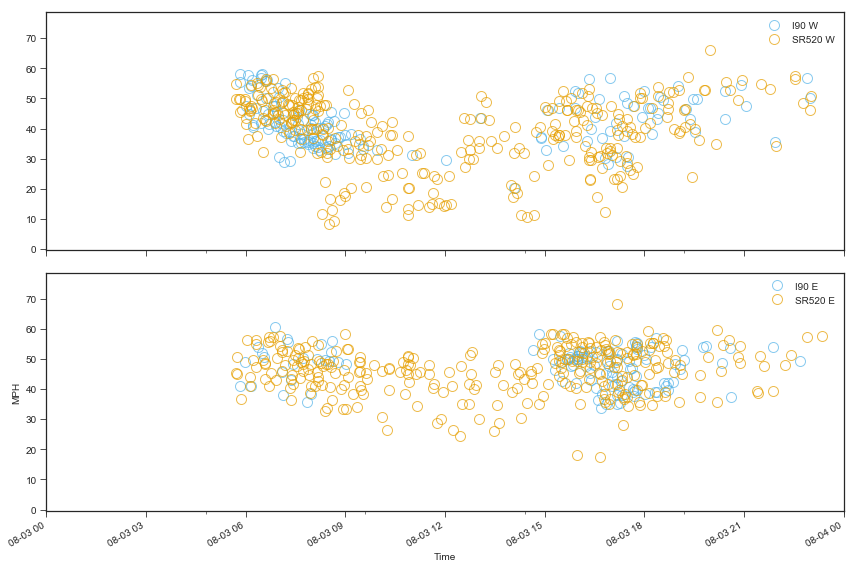

In [43]:
day=3
month=8

kwargs = {'lw':0, 'marker':'o', 'markersize':10, 'alpha':.7, 'mfc':'none'}
start=dt.date(2017,month,day)
end=dt.date(2017,month,day+1)
fig,(ax1,ax2) = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
df_WI90.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
df_WSR520.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
ax1.legend(['I90 W', 'SR520 W'])
df_EI90.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
df_ESR520.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
ax2.legend(['I90 E', 'SR520 E'])
plt.xlim(start,end)
plt.ylabel('MPH')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

And here we can see a week of data. Note that we can pick out the weekends easily by looking for the lack of traffic.

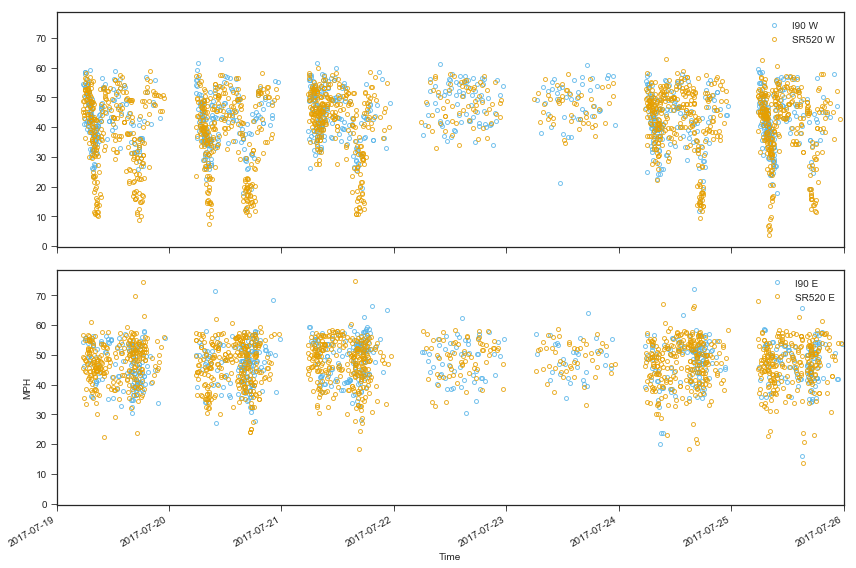

In [38]:
day=19
month=7
kwargs = {'lw':0, 'marker':'o', 'markersize':4, 'alpha':.8, 'mfc':'none'}
start=dt.date(2017,month,day)
end=dt.date(2017,month,day+7)
fig,(ax1,ax2) = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
df_WI90.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
df_WSR520.plot(ax=ax1, x='datetime', y='simpleMPH', **kwargs)
ax1.legend(['I90 W', 'SR520 W'])
df_EI90.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
df_ESR520.plot(ax=ax2, x='datetime', y='simpleMPH', **kwargs)
plt.xlim(start,end)
plt.legend(['I90 E', 'SR520 E'])
plt.ylabel('MPH')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

Now we play around with different ways of trying to summarize the data.
Here we're following PythonDataScienceHandbook: jakevdp.github.io/PythonDataScienceHandbook

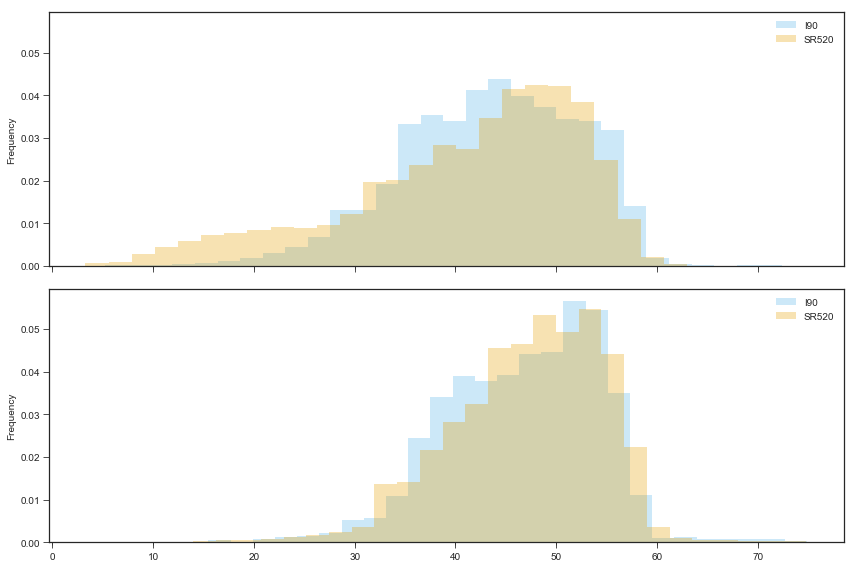

In [31]:
kind='hist'
options={'bins':30, 'normed':True, 'alpha':.3}
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
df_WI90.plot(ax=ax1, kind=kind, x='date', y='simpleMPH', label='I90', **options)
df_WSR520.plot(ax=ax1, kind=kind, x='date', y='simpleMPH', label='SR520', **options)
df_EI90.plot(ax=ax2, kind=kind, x='date', y='simpleMPH', label='I90', **options)
df_ESR520.plot(ax=ax2, kind=kind, x='date', y='simpleMPH', label='SR520', **options)
plt.tight_layout()
plt.show()

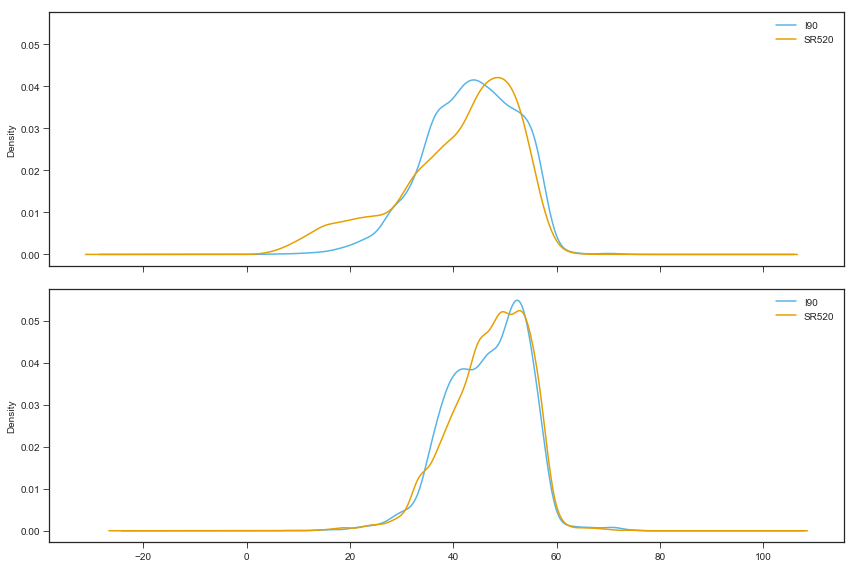

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
df_WI90.plot(ax=ax1, kind='kde', x='date', y='simpleMPH', label='I90')
df_WSR520.plot(ax=ax1, kind='kde', x='date', y='simpleMPH', label='SR520' )
df_EI90.plot(ax=ax2, kind='kde', x='date', y='simpleMPH', label='I90')
df_ESR520.plot(ax=ax2, kind='kde', x='date', y='simpleMPH', label='SR520')
plt.tight_layout()
plt.show()

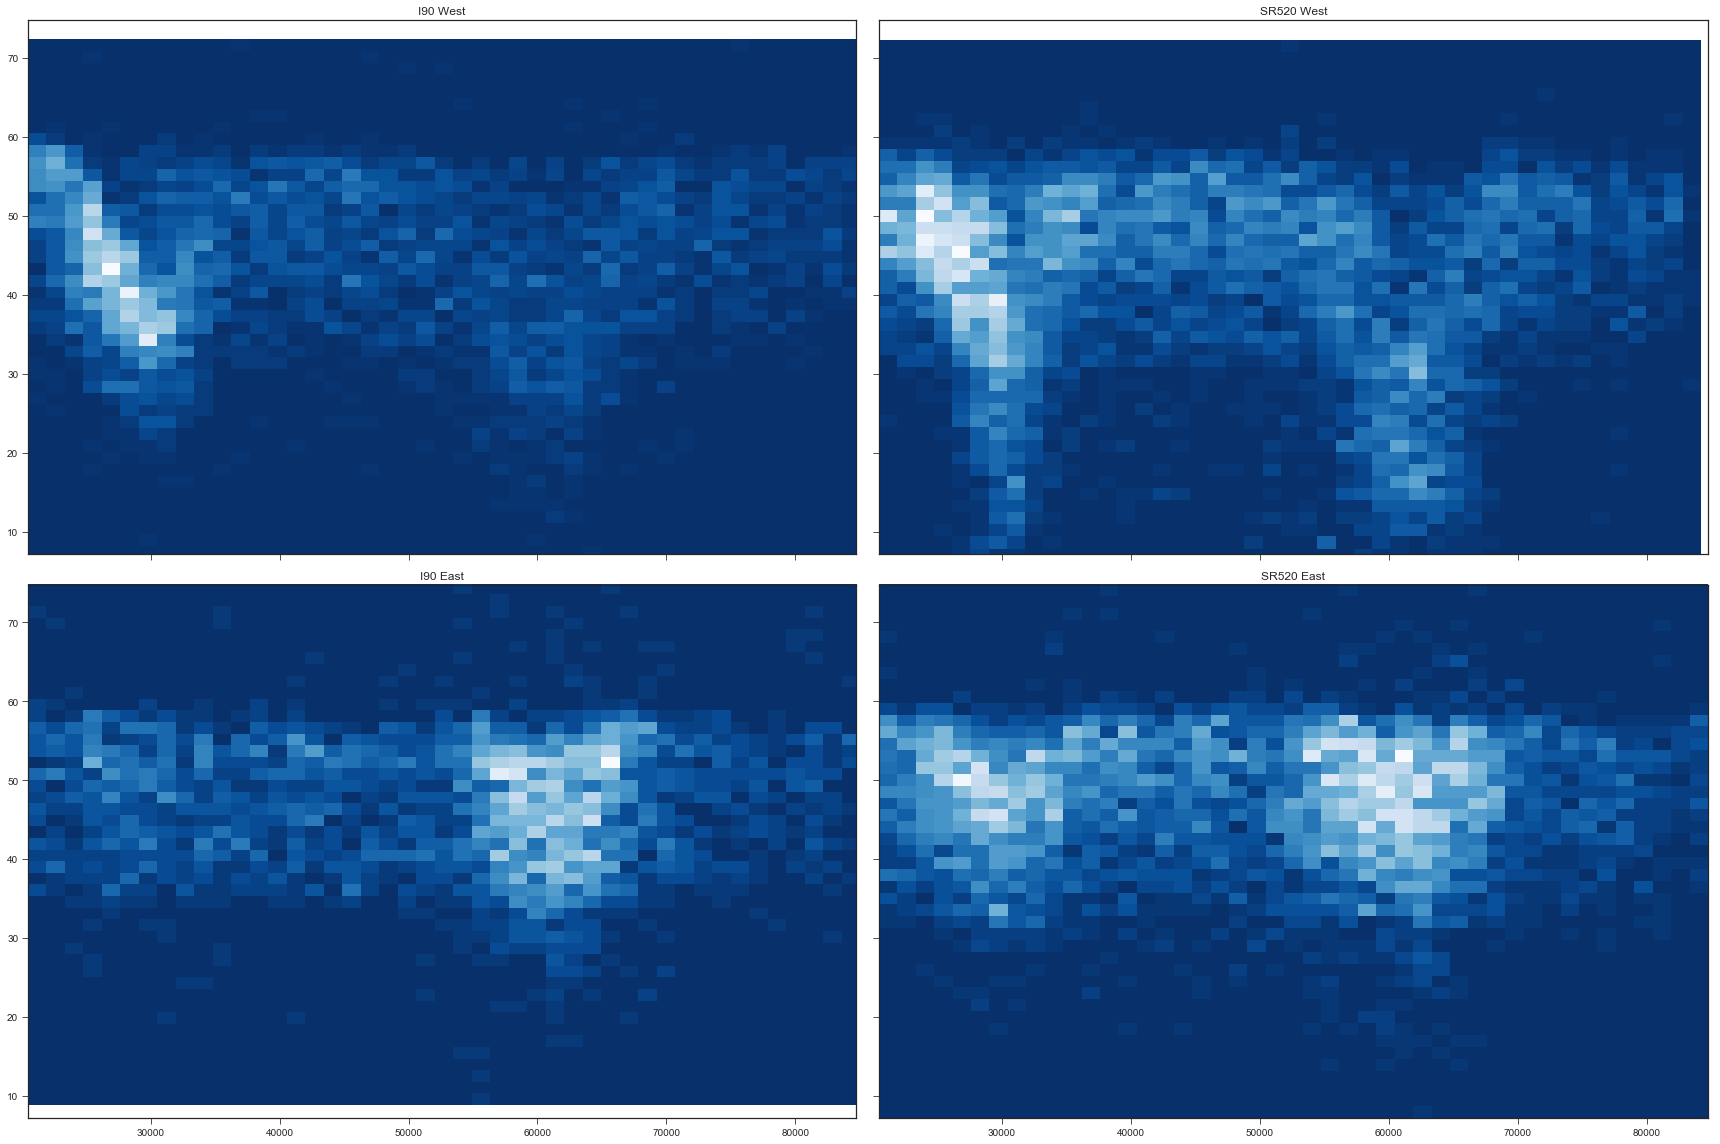

In [15]:

kwargs={'normed':False, 'cmap':'Blues_r', 'bins':45};

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(24,16), sharex=True, sharey=True);

h1=ax1.hist2d(df_WI90['timeofdaysec'], df_WI90['simpleMPH'], **kwargs);
h2=ax2.hist2d(df_WSR520['timeofdaysec'], df_WSR520['simpleMPH'], **kwargs);
h3=ax3.hist2d(df_EI90['timeofdaysec'], df_EI90['simpleMPH'], **kwargs);
h4=ax4.hist2d(df_ESR520['timeofdaysec'], df_ESR520['simpleMPH'], **kwargs);
ax1.set_title('I90 West')
ax2.set_title('SR520 West')
ax3.set_title('I90 East')
ax4.set_title('SR520 East')
#fig.colorbar(h1[3], ax=[ax1, ax2, ax3, ax4])
plt.tight_layout()
plt.show()

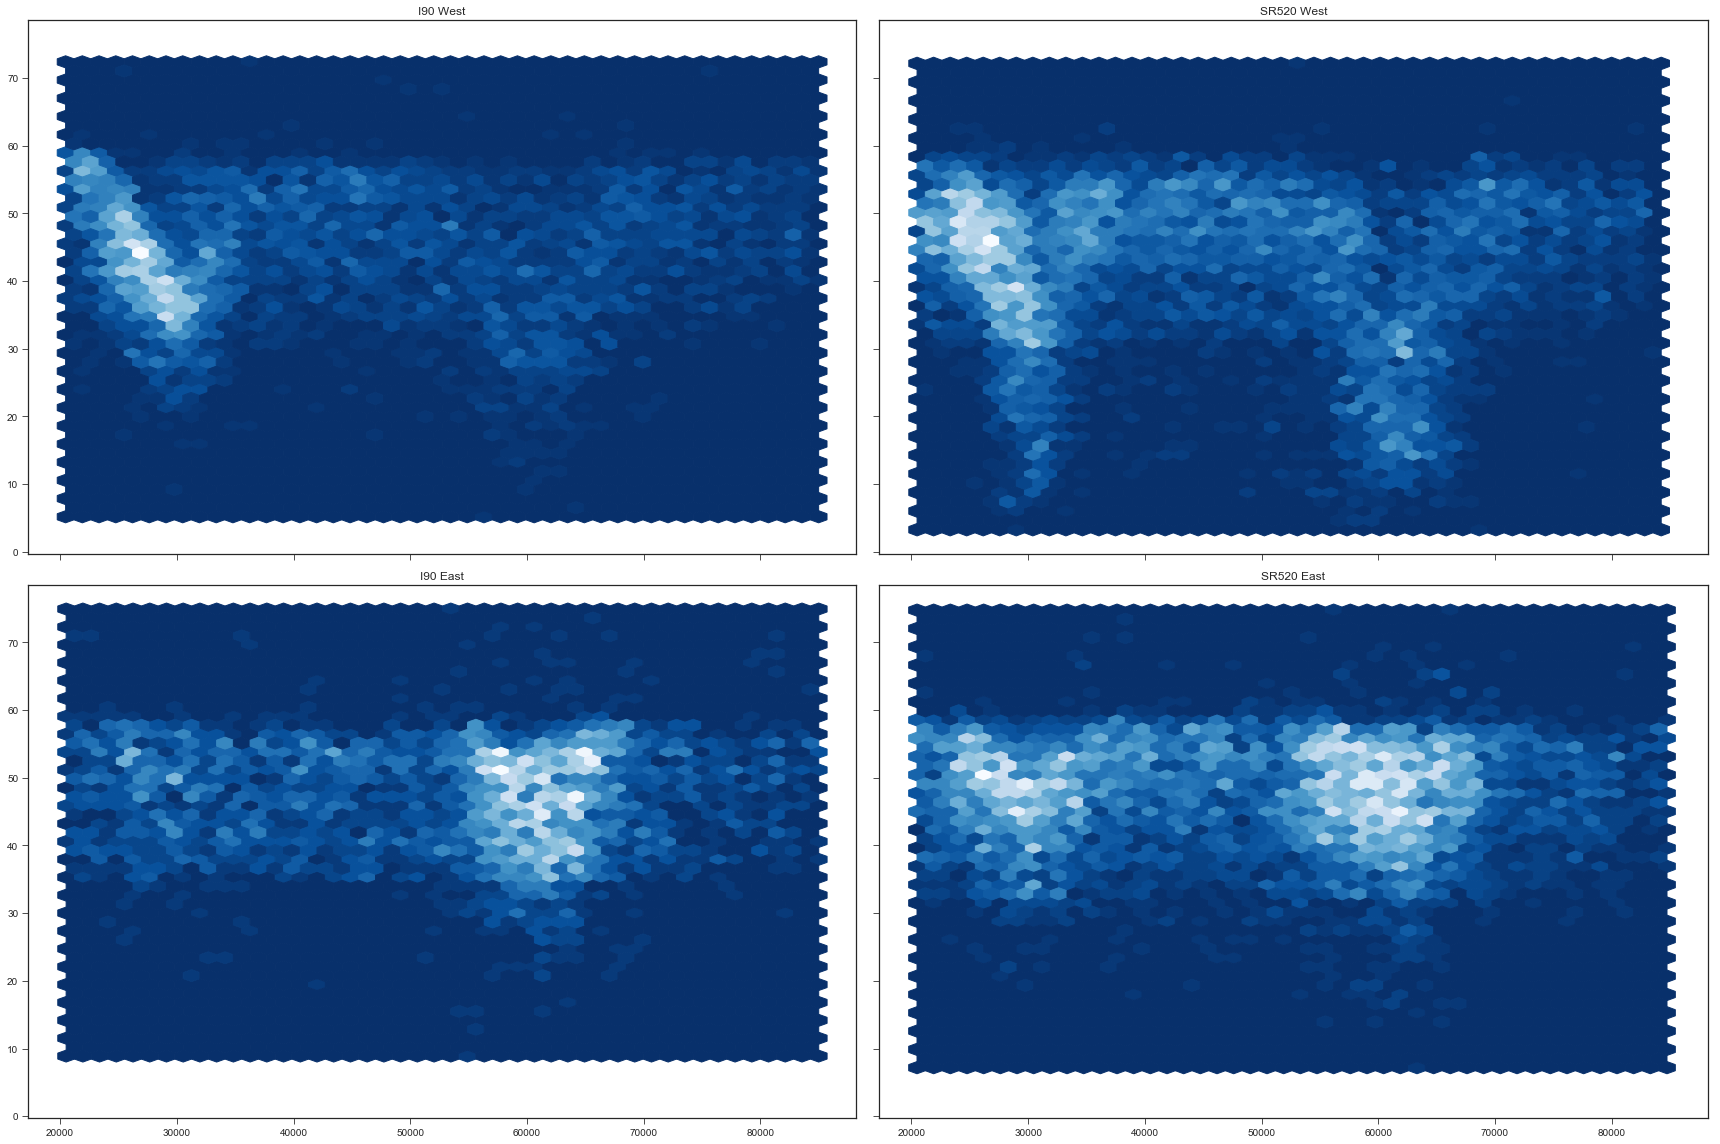

In [16]:
kwargs={'cmap':'Blues_r', 'gridsize':45};

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(24,16), sharex=True, sharey=True);

ax1.hexbin(df_WI90['timeofdaysec'], df_WI90['simpleMPH'], **kwargs)
ax2.hexbin(df_WSR520['timeofdaysec'], df_WSR520['simpleMPH'], **kwargs)
ax3.hexbin(df_EI90['timeofdaysec'], df_EI90['simpleMPH'], **kwargs)
ax4.hexbin(df_ESR520['timeofdaysec'], df_ESR520['simpleMPH'], **kwargs)
ax1.set_title('I90 West')
ax2.set_title('SR520 West')
ax3.set_title('I90 East')
ax4.set_title('SR520 East')
plt.tight_layout()
plt.show()

In [17]:
def smoothAnalysis(ax, df, aText, bText, title,numGrid=100,):
    from scipy.stats import gaussian_kde

    # fit an array of size [Ndim, Nsamples]
    data = np.vstack([df[aText], df[bText]])
    kde = gaussian_kde(data)

    # evaluate on a regular grid\
    xStart=0
    xEnd=90000
    yStart=0
    yEnd=75
    xgrid = np.linspace(xStart, xEnd, numGrid)
    ygrid = np.linspace(yStart, yEnd, numGrid)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
    ax.set_title(title)
    # Plot the result as an image
    ax.imshow(Z.reshape(Xgrid.shape),
               origin='lower', aspect='auto',
               extent=[xStart, xEnd, yStart, yEnd],
               cmap='Blues_r')
    #cb = plt.colorbar()
    #cb.set_label("density")

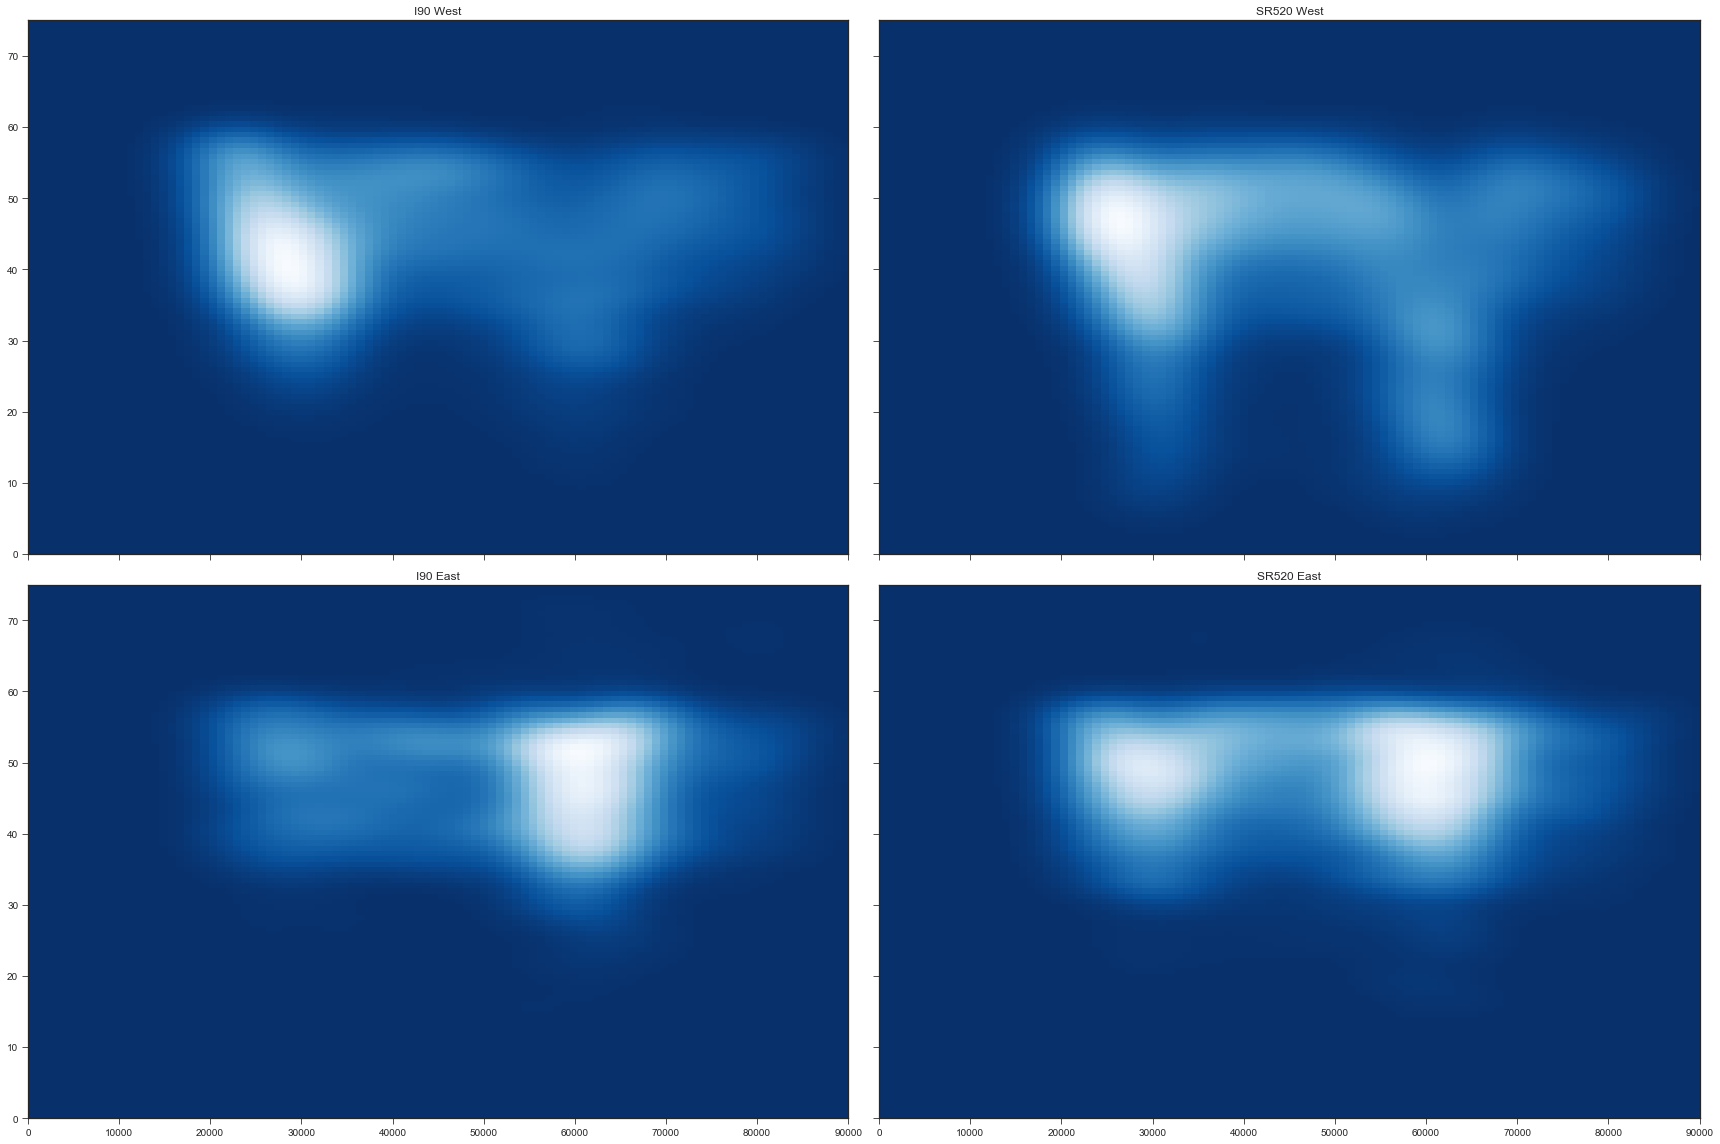

In [18]:
kwargs={'cmap':'Blues_r', 'gridsize':45};

fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(24,16), sharex=True, sharey=True);
smoothAnalysis(ax1, df_WI90, 'timeofdaysec', 'simpleMPH', 'I90 West')
smoothAnalysis(ax2, df_WSR520, 'timeofdaysec', 'simpleMPH', 'SR520 West')
smoothAnalysis(ax3, df_EI90, 'timeofdaysec', 'simpleMPH', 'I90 East')
smoothAnalysis(ax4, df_ESR520, 'timeofdaysec', 'simpleMPH', 'SR520 East')
plt.tight_layout()
plt.show()